In [1]:
# Hypothesis: smaller kernel sizes will lead to higher accuracies of classification in fined-tuned image classification
# We think this is likely due to the ability of the CNN to detect smaller features between relatively similar images of the same species
# Independent Variables: kernel size
# Constant Variables: number of layers, types of layers, input shape, epoches, hyperparamaters(depth,padding)
# Dependent Variables: Accuracy
# Limitations: we are foregoing pure accuracy for experimental reasons - we could get higher accuracy if we tried but we're keeping
# things constant for consistancy between models
# Currently only using Input, Convolutional, Relu, Pool, and FC/Dense layers. Can add Dense and Dropout if we have time
# Reference to www.cs231n.github.io/convolutional-networks

In [2]:
# 3. Import libraries and modules
import os, cv2, argparse
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from numpy.random import RandomState
np.random.seed(123)  # for reproducibility
import sys
import random

/home/cfu288/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def shuffle_data(arr1, arr2):
    seed = random.randint(0, 1000)
    ran = RandomState(seed)
    ran.shuffle(arr1)
    ran = RandomState(seed)
    ran.shuffle(arr2)

In [4]:
# INPUT
TRAIN_DIR = './training/'
TEST_DIR = './validation/'
EPOCHS = 10

In [12]:
# Setup, Read in images, Preprocess images for training
TRAIN_IMG, TRAIN_CLS, TEST_IMG, TEST_CLS = ([] for i in range(4))
COLS = ['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images']
LABELS = pd.read_csv('./monkey_labels.txt', names=COLS, skiprows=1)
CLASSES = [x for x in range(0, len(LABELS))]

# read in all images
# resizing the images to 100x100 to make training faster
print("READING IN AND FORMATTING IMAGES")
for x in range(0, len(LABELS)):
    train_dir = TRAIN_DIR + LABELS.loc[x,'Label'].strip() + '/'
    test_dir = TEST_DIR + LABELS.loc[x,'Label'].strip() + '/'
    for file in os.listdir(train_dir):
        if not file.endswith('jpg'):
            print("empty file")
            continue
        img = cv2.imread(train_dir + file)
        if img is not None:
            img = cv2.resize(img, (150, 150))
            TRAIN_IMG.append(img)
            TRAIN_CLS.append(x)
    for file in os.listdir(test_dir):
        img = cv2.imread(test_dir + file)
        if img is not None:
            img = cv2.resize(img, (150, 150))
            TEST_IMG.append(img)
            TEST_CLS.append(x)
print("COMPLETE")

READING IN AND FORMATTING IMAGES
empty file
COMPLETE


In [13]:
# convert to numpy arrays
TRAIN_IMG = np.array(TRAIN_IMG)
TEST_IMG = np.array(TEST_IMG)
TRAIN_CLS = np.array(TRAIN_CLS)
TEST_CLS = np.array(TEST_CLS)

# Preprocess images
# Reshape them to theanos format (channels, hight, width) # changed to tensorflow
# Convert to 0-255 to value in [0-1]
# TRAIN_IMG = TRAIN_IMG.reshape(TRAIN_IMG.shape[0], 3, 100, 100)
# TEST_IMG = TEST_IMG.reshape(TEST_IMG.shape[0], 3, 100, 100)
TRAIN_IMG = TRAIN_IMG.astype('float32')
TEST_IMG = TEST_IMG.astype('float32')
TRAIN_IMG /= 255
TEST_IMG /= 255

# Reshape class labels
TRAIN_CLS = np_utils.to_categorical(TRAIN_CLS, 10)
TEST_CLS = np_utils.to_categorical(TEST_CLS, 10)

# Shuffle the data
shuffle_data(TRAIN_IMG, TRAIN_CLS)
shuffle_data(TEST_IMG, TEST_CLS)

In [ ]:
#Inc training data through image aug
shift = 0.2
#datagen = ImageDataGenerator()
datagen = ImageDataGenerator(rotation_range=90)
#datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
#datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(TRAIN_IMG)
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

for X_batch, y_batch in datagen.flow(TRAIN_IMG, TRAIN_CLS, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(100, 100, 3), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

In [8]:
# Construct the model - MINST

# This model was used in a tutorial for MINST images, but gets a 50% on our test set
# after 10 epoches
# model = Sequential()
# model.add(Conv2D(110, (3, 3), activation='relu', input_shape=(100, 100, 3)))
# model.add(Conv2D(110, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))

### Why CNN over NN?
    Regular FC NN don't scale well to images - too many weights and too connected - leads to over fitting and long
    compute times
    Instead of connecting densely like a NN, a CNN layer only connects the neurons in a layer to a small region of 
    the layer before it. Also allows for reducing the image to a single vector in the end.

### What is a Convolutional layer?
    A convolutional layer is a 3D layer (vs a 1D layer in a dense) where the depth of the layer is the number of
    learnable filters. A filter is a set of weights inna 3d matrix that transveres over the input image. Each filter 
    is small spatially (width and height wise), but extend the depth of the input (so 3 for our case). A typical 
    filter may be [5x5x3] - 5 pixels wide and high, 3 deep. During the forward pass, we slide(convolve) each filter 
    across the width and height of the input and compute dot products between the filter and the input.

### What do these filters do?
    As we slide these filters across the input image, we build a 2d activation map that gives the responses of that
    specific filter at each point in the image. What this means is that the filters scan the input for "features" 
    like edges or areas of high contrast, and the filter will be "activated" when it passes its "feature" on the 
    input image. We can see where in the image a feature was found by seeing where on the the 2d activation 
    map is activated for the filter that is detecting that feature. Convolutional layers deeper in the 
    architecture might be able to detect more complex attributes in the image like patterns, small objects(eyes, 
    wheels), etc.

### How big is the volume of a Convolutional layer (Height,Width,Depth) given:
    INPUT_SIZE(W), FILTER_SIZE(F), NUM_OF_FILTERS, STRIDE(S), PADDING(P)
      Padding - It is a HYPERPARAMATER. Pad the input volume with zeros around the border. Generally used to control the
        spacial size of the output volumes, usually to match size size of the input volume.
      Stride - amount of pixels we shift each filter by when scanning. Stride of 1 means we move filters one pixel 
        at a time. Larger strides lead to a smaller output volume in the layer
      Depth - It is a HYPERPARAMATER. It corresponds to the number of filters we want to use. Each filter looks for 
        something different in input. 
    Volume = (W−F+2P)/S+1 
    Our CNN has an input of 100x100, filter of 3x3, no padding, stride of 1, 110 number of filters. 
    (100-3) + 1 = 98, so the output layer contains 98x98x110 neurons.

### What does this mean for our Convolutional layer?
    Each neuron from the [98x98x110] output volume is attached to a [3x3x3] filter in the input volume.
    All the neurons in the same area in the depth column (so 110 of them) actually map to the exact same
    filter on the input, but each should have different numerical outputs since each filter is looking for a 
    different feature.
    With [98x98x110] neurons in this Convolutional layer, each neuron with [3x3x3] weighs and 1 bias. This means
    that this layer has 29,580,320 paramaters.

In [14]:
# Alternate Model - Simple

# Trying to use the simplest CNN possible - From here we can mess with the kernel and see if kernel size helps 
# with fine tuned classification
# Hypothesis: smaller kernel sizes will lead to higher accuracies of classification in fined-tuned image classification
# Independent Variables: kernel size
# Constant Variables: number of layers, types of layers, input shape, epoches
# Dependent Variables: Accuracy
# Limitations: we are foregoing pure accuracy for experimental reasons - we could get higher accuracy if we tried but we're keeping
# things constant for consistancy between models
# Currently only using Input, Convolutional, Relu, Pool, and FC/Dense layers. Can add Dropout(overfitting) if we have time
# Reference to www.cs231n.github.io/convolutional-networks
# Building a CNN generally requires 4 major steps: Convolution, Pooling, Flattening, Full Connection
test_kernel = (3,3)
num_filters = 256
input_shape=(150,150,3)

simple_model = Sequential()
# INPUT LAYER - Hold raw pixel values of an image, width 100, height 100, and with 3 color channels
# CONVOLUTIONAL LAYER - Compute the output of neurons connected to local regions in the input, each computing the dot 
#   product vetween their weights and a small region (decided by filter) they are connected to in the input volume
simple_model.add(Conv2D(num_filters, test_kernel, input_shape=input_shape))
# RELU LAYER - Apply an elemntwise activation function, max(0,x). Leaves the size of the volume unchanged, used to normalize output. Can be added a paramater to the previous layer but seperated for clarity
simple_model.add(Activation('relu'))
# POOL LAYER - Perform a downsampling operation along the psatial dimentions (width, height) resulting in a smaller volume
simple_model.add(MaxPooling2D(pool_size=(2,2)))
simple_model.add(Flatten()) # Converts and connects multi-dimentional convolutional layer into a 1D feature vector to be used for final classification
# FULLY CONNECTED LAYER - Compute class scores, resulting in a volume size of [1x1x10], where each of the 10 numbers represents a class
simple_model.add(Dense(10, activation='softmax'))

In [11]:
# Compile MINIST model
# print("COMPILING MINIST MODEL")
# # Adam - Modified Gradient Decent - learning rate changes as it nears
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Compile SIMPLE model
print("COMPILING SIMPLE MODEL")
# Adam - Modified Gradient Decent - learning rate changes as it nears
simple_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("DONE COMPILING MODEL")

COMPILING SIMPLE MODEL
DONE COMPILING MODEL


In [13]:
# Train the model on the training data
# print("TRAINING FOR {} EPOCHS".format(EPOCHS)) 
# history = model.fit(TRAIN_IMG, TRAIN_CLS, batch_size=32, epochs=EPOCHS, verbose=1, validation_split=0.2, shuffle=True)

In [16]:
# Train SIMPLE model on the training data
# Note: Probably overfitting this model, hit 100% on training before 10 iterations
print("TRAINING SIMPLE MODEL FOR {} EPOCHS using {} kernel size".format(EPOCHS, test_kernel)) 
history = simple_model.fit(TRAIN_IMG, TRAIN_CLS, batch_size=32, epochs=EPOCHS, verbose=1, validation_split=0.1, shuffle=True)

TRAINING SIMPLE MODEL FOR 10 EPOCHS using (3, 3) kernel size
Train on 877 samples, validate on 220 samples
Epoch 1/10
877/877 [==============================] - 74s 85ms/step - loss: 7.4663 - acc: 0.1653 - val_loss: 2.1487 - val_acc: 0.2500
Epoch 2/10
877/877 [==============================] - 73s 84ms/step - loss: 1.6449 - acc: 0.4652 - val_loss: 1.4126 - val_acc: 0.5455
Epoch 3/10
877/877 [==============================] - 72s 82ms/step - loss: 0.6992 - acc: 0.8039 - val_loss: 1.2472 - val_acc: 0.5682
Epoch 4/10
877/877 [==============================] - 70s 80ms/step - loss: 0.2479 - acc: 0.9521 - val_loss: 1.1185 - val_acc: 0.6136
Epoch 5/10
877/877 [==============================] - 72s 82ms/step - loss: 0.0847 - acc: 0.9863 - val_loss: 0.9956 - val_acc: 0.6455
Epoch 6/10
877/877 [==============================] - 72s 82ms/step - loss: 0.0268 - acc: 1.0000 - val_loss: 1.0136 - val_acc: 0.6409
Epoch 7/10
877/877 [==============================] - 71s 82ms/step - loss: 0.0033 - acc:

In [15]:
# Save the model
# print("SAVE MODEL")
# model.save('test_model.h5')
# print(history.history.keys())

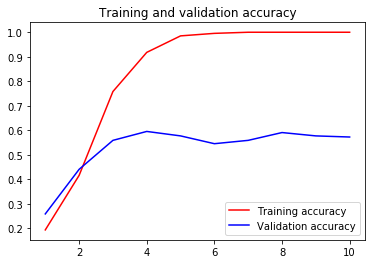

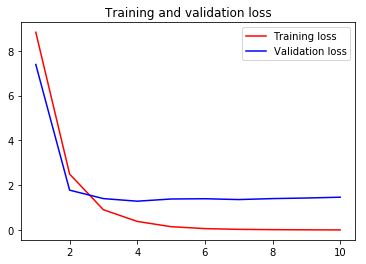

In [10]:
# TODO - Print a plot of loss and accuracy over epochs and learning rates
# TODO - Print a plot of loss and accuracy over epochs and learning rates
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [17]:
#model = load_model('test_model.h5')

# Evaluate the model on the validation data
# loss, acc = model.evaluate(TEST_IMG, TEST_CLS, verbose=1)
# print("Loss: ", loss, " Accuracy: ", acc)

In [ ]:
# Save and Evaluate the SIMPLE model on the validation data
#print("SAVE SIMPLE MODEL")
#simple_model.save('models/simple_model.h5')
print(history.history.keys())
loss, acc = simple_model.evaluate(TEST_IMG, TEST_CLS, verbose=1)
print("Loss: ", loss, " Accuracy: ", acc)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
 96/272 [=========>....................] - ETA: 3s

In [19]:
# # Append results to the end of a text file
# with open("results_simple_cnn.txt", 'a') as f:
#     f.write('{{ "accuracy":{}, "epochs":{}, "kernel":"{}", "num_filters":{}, "input_shape":"{}" }} \n'.format(
#         acc, EPOCHS, test_kernel, num_filters, input_shape))

In [20]:
# Predict images
# TODO - Print mispredicted images, the label it predicted, and the correct label
'''
for i in range(len(TEST_IMG)):
    img = TEST_IMG[i]
    cls = TEST_CLS[i]
    img = np.array([img])
    prediction = model.predict(img, verbose=1, steps=1)
    print
    print "Class: ", cls
    print "Prediction: ", prediction[0]
    max_index = np.argmax(prediction[0])
    print "Predicted Class index: ", max_index
    print "Prediction Correct: ", True if cls[max_index] == 1. else False
'''

'\nfor i in range(len(TEST_IMG)):\n    img = TEST_IMG[i]\n    cls = TEST_CLS[i]\n    img = np.array([img])\n    prediction = model.predict(img, verbose=1, steps=1)\n    print\n    print "Class: ", cls\n    print "Prediction: ", prediction[0]\n    max_index = np.argmax(prediction[0])\n    print "Predicted Class index: ", max_index\n    print "Prediction Correct: ", True if cls[max_index] == 1. else False\n'